<a href="https://colab.research.google.com/github/demacdolincoln/adversarial_talk/blob/master/advertorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture

!pip install advertorch

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import torch
import torch.nn as nn

from torchvision.models import resnet101, vgg16

from advertorch.utils import predict_from_logits
from advertorch.utils import NormalizeByChannelMeanStd

from advertorch_examples.utils import ImageNetClassNameLookup
from advertorch_examples.utils import get_panda_image
from advertorch_examples.utils import bhwc2bchw
from advertorch_examples.utils import bchw2bhwc

import cv2

In [0]:
plt.style.use('dark_background')

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
def tensor2npimg(tensor):
    return bchw2bhwc(tensor[0].cpu().numpy())

In [0]:
def show_results(images, labels):
    fig, ax = subplots(1, 3, figsize=(10,5))

    for i in range(3):
        ax[i].imshow(tensor2npimg(images[i]))
        ax[i].set_title(labels[i])
        ax[i].axis('off')

    fig.tight_layout()

In [8]:
normalize = NormalizeByChannelMeanStd(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
model = resnet101(pretrained=True)
model.eval()
model = nn.Sequential(normalize, model)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
np_img = get_panda_image()
img = torch.tensor(bhwc2bchw(np_img))[None, :, :, :].float().to(device)
label = torch.tensor([388, ]).long().to(device)
imagenet_label2classname = ImageNetClassNameLookup()

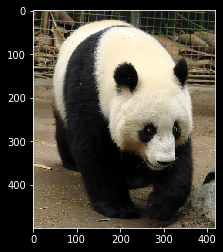

In [25]:
imshow(np_img)

In [0]:
from advertorch.attacks import SparseL1DescentAttack, L2PGDAttack

In [27]:
predict_original = imagenet_label2classname(
    model(img).argmax()
    )

predict_original

'giant_panda'

In [0]:
adv = L2PGDAttack(model, eps=1., eps_iter=2/40, nb_iter=40, rand_init=True)

# adv = SparseL1DescentAttack(model, eps=1000., eps_iter=2*1000./40, nb_iter=40,
    # rand_init=True, targeted=False)

In [0]:
adv_img = adv.perturb(img, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


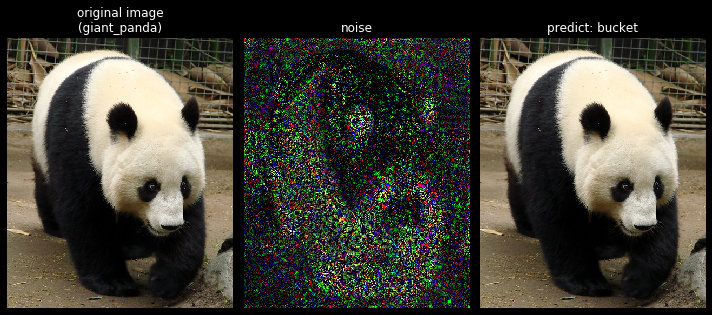

In [30]:
predict_pertub = imagenet_label2classname(
    model(adv_img).argmax()
)
show_results([img, (adv_img-img)*270, adv_img], [f'original image\n({predict_original})', 'noise', f'predict: {predict_pertub}'])